Activists have asserted that there is a strong gender bias in student evaluations of professors, with 
male professors enjoying a boost in rating from this bias. While this has been celebrated by ideologues, 
skeptics have pointed out that this research is of technically poor quality, either due to a low sample 
size – as small as n = 1 (Mitchell & Martin, 2018), failure to control for confounders such as teaching 
experience (Centra & Gaubatz, 2000) or obvious p-hacking (MacNell et al., 2015). We would like you to 
answer the question whether there is evidence of a pro-male gender bias in this dataset.  
Hint: A significance test is probably required.


The columns represent the following information, in order:
1. Average Rating (the arithmetic mean of all individual quality ratings of this professor)
2. Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)
3. Number of ratings (simply the total number of ratings these averages are based on)
4. Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)
5. The proportion of students that said they would take the class again
6. The number of ratings coming from online classes
7. Male gender (Boolean – 1: determined with high confidence that professor is male)
8. Female (Boolean – 1: determined with high confidence that professor is female)


In [122]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [123]:
'''
Columns are:
1. Average Rating (the arithmetic mean of all individual quality ratings of this professor)
2. Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)
3. Number of ratings (simply the total number of ratings these averages are based on)
4. Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)
5. The proportion of students that said they would take the class again
6. The number of ratings coming from online classes
7. Male gender (Boolean – 1: determined with high confidence that professor is male)
8. Female (Boolean – 1: determined with high confidence that professor is female)
'''
df_capstone = pd.read_csv('./rmpCapstoneNum.csv', header=None)
df_capstone.columns = ['Average Rating', 'Average Difficulty', 'Number of ratings', 'Received a pepper', 
                       'Proportion of students that said they would take the class again', 
                       'Number of ratings coming from online classes', 'Male Professor', 'Female Professor']


In [124]:
# Load the dataset

df_capstone_num = pd.read_csv('./rmpCapstoneNum.csv', header=None)

In [125]:
df_capstone_num.head()

,0,1,2,3,4,5,6,7
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0


In [126]:
# Get column 0, 2, 6 & 7
# Column 0: 'AverageProfessorRating'
# Column 2: 'NumberOfRatings'
# Column 6: 'HighConfMale'
# Column 7: 'HighConfFemale'

df_capstone_num = df_capstone_num.iloc[:, [0, 2, 6, 7]]

df_capstone_num.columns = ['AverageProfessorRating', 'NumberOfRatings', 'HighConfMale', 'HighConfFemale']

df_capstone_num.head()

,AverageProfessorRating,NumberOfRatings,HighConfMale,HighConfFemale
0,5.0,2.0,0,1
1,NaN,NaN,0,0
2,3.2,4.0,1,0
3,3.6,10.0,0,0
4,1.0,1.0,0,0


In [127]:
# Check for missing values
df_capstone_num.isnull().sum()

AverageProfessorRating    19889
NumberOfRatings           19889
HighConfMale                  0
HighConfFemale                0
dtype: int64

In [128]:
# Clean the dataset
df_capstone_num_clean = df_capstone_num.dropna()

In [129]:
# Lets look at the summary statistics of the dataset
df_capstone_num_clean.describe()

,AverageProfessorRating,NumberOfRatings,HighConfMale,HighConfFemale
count,70004.000000,70004.000000,70004.000000,70004.000000
mean,3.808014,5.374721,0.419633,0.387678
std,1.126895,8.136628,0.493502,0.487224
min,1.000000,1.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000
50%,4.000000,3.000000,0.000000,0.000000
75%,4.800000,6.000000,1.000000,1.000000
max,5.000000,393.000000,1.000000,1.000000


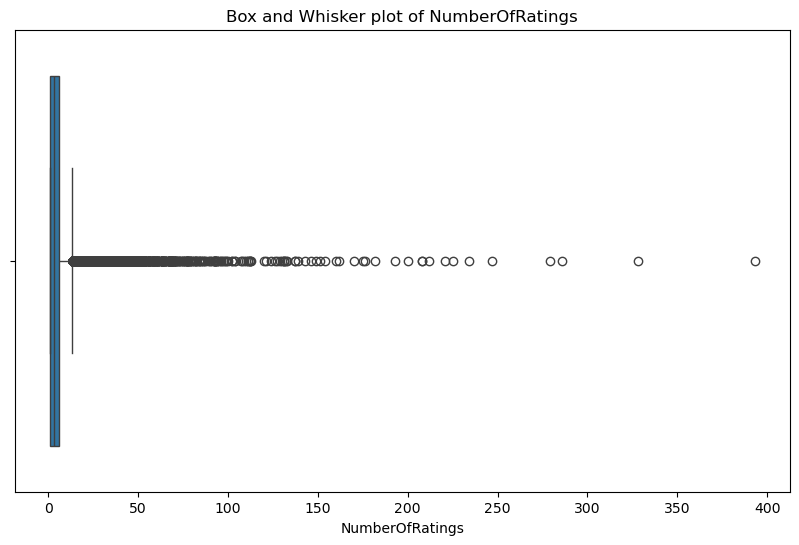

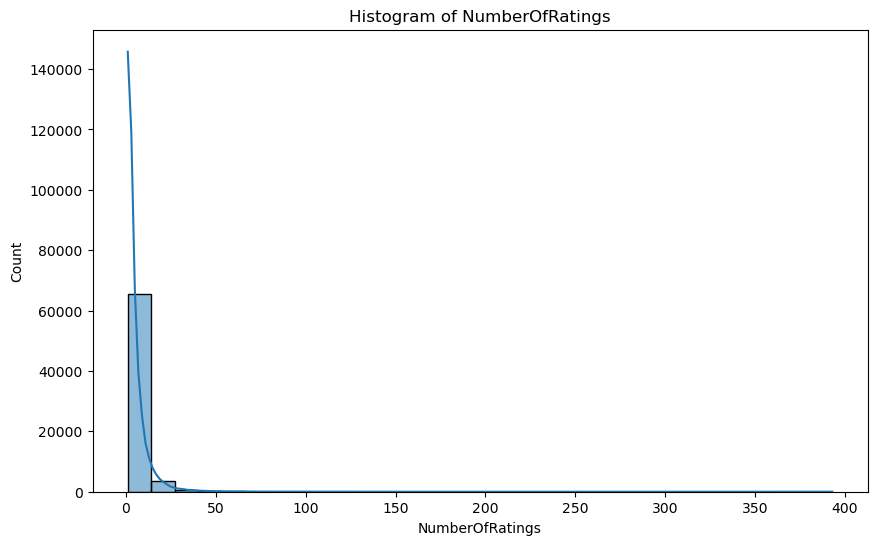

In [130]:
# Plot NumberOfRatings as a box and whisker plot
plt.figure(figsize=(10, 6))

sns.boxplot(x='NumberOfRatings', data=df_capstone_num_clean)

plt.title('Box and Whisker plot of NumberOfRatings')

plt.show()
# Plot NumberOfRatings as a histogram
plt.figure(figsize=(10, 6))

sns.histplot(df_capstone_num_clean['NumberOfRatings'], bins=30, kde=True)

plt.title('Histogram of NumberOfRatings')

plt.show()

The minimum number of students was based on Centra's (1998) research, indicating that scores based on 10 or more students provide a sufficient level
of reliability for research purposes.

https://slate.com/technology/2018/04/hotness-affects-student-evaluations-more-than-gender.html

In [131]:
# Number of professors with less than 10 ratings vs more than 10 ratings
print('Number of professors with less than 10 ratings: ', len(df_capstone_num_clean[df_capstone_num_clean['NumberOfRatings'] < 10]))
print('Number of professors with more than 10 ratings: ', len(df_capstone_num_clean[df_capstone_num_clean['NumberOfRatings'] >= 10]))

Number of professors with less than 10 ratings:  60163
Number of professors with more than 10 ratings:  9841


In [132]:
# Number of those profressors with more than 10 ratings that are male
print('Number of professors with more than 10 ratings that are male: ', len(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfMale'] == 1)]))
print('Number of professors with more than 10 ratings that are female: ', len(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfFemale'] == 1)]))

Number of professors with more than 10 ratings that are male:  4288
Number of professors with more than 10 ratings that are female:  3419


In [133]:
# Proportion of men and women with more than 10 ratings
men_more_than_10 = len(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfMale'] == 1)])
women_more_than_10 = len(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfFemale'] == 1)])

total_men = len(df_capstone_num_clean[df_capstone_num_clean['HighConfMale'] == 1])
total_women = len(df_capstone_num_clean[df_capstone_num_clean['HighConfFemale'] == 1])

proportion_men_more_than_10 = men_more_than_10 / (men_more_than_10 + women_more_than_10) if total_men > 0 else 0
proportion_women_more_than_10 = women_more_than_10 / (men_more_than_10 + women_more_than_10) if total_women > 0 else 0

print('Proportion of men with more than 10 ratings: ', proportion_men_more_than_10)
print('Proportion of women with more than 10 ratings: ', proportion_women_more_than_10)

Proportion of men with more than 10 ratings:  0.5563773193200986
Proportion of women with more than 10 ratings:  0.4436226806799014


In [134]:
# Median rating of professors with more than 10 ratings who are male vs female
median_rating_male = df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'].median()
median_rating_female = df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'].median()

print('Median rating of professors with more than 10 rating male', median_rating_male, 'Female', median_rating_female)

Median rating of professors with more than 10 rating male 4.3 Female 4.2


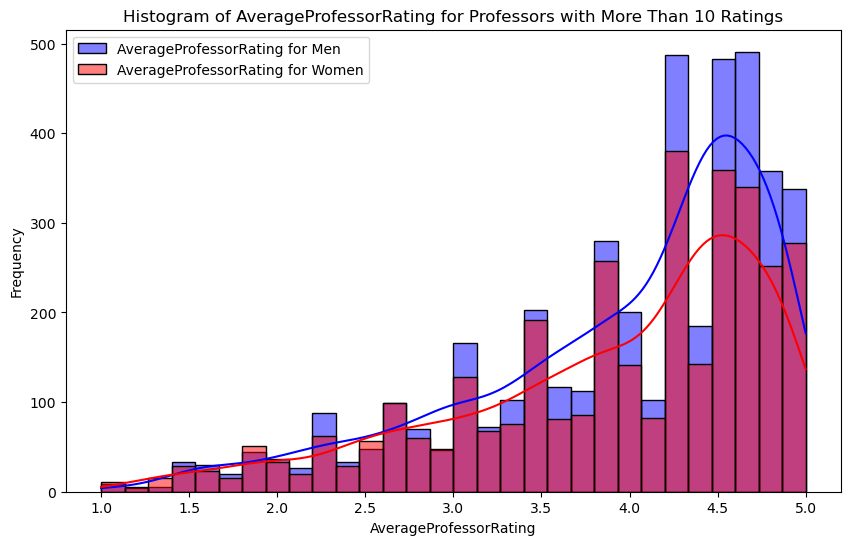

In [135]:
# Plot the histogram of the AverageProfessorRating for professors with more than 10 ratings for women and men separately
plt.figure(figsize=(10, 6))

sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='blue', label='AverageProfessorRating for Men')
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='red', label='AverageProfessorRating for Women')

plt.title('Histogram of AverageProfessorRating for Professors with More Than 10 Ratings')
plt.xlabel('AverageProfessorRating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

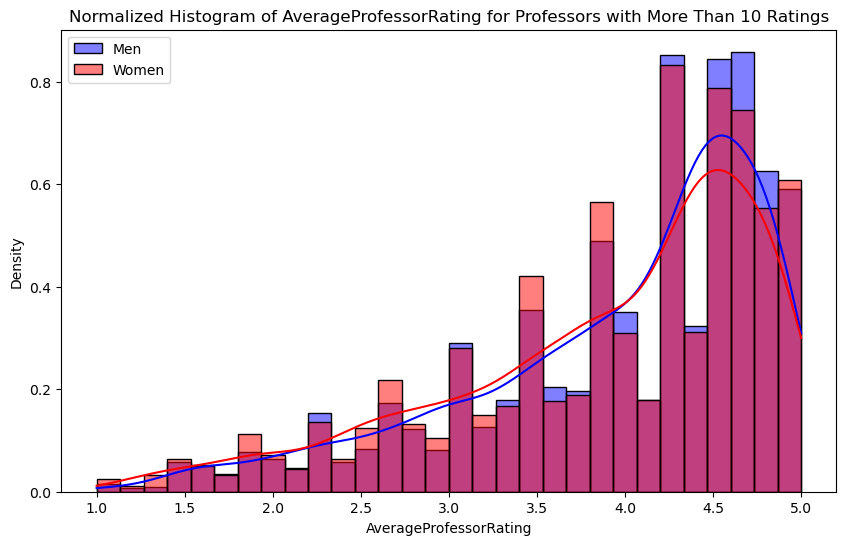

In [136]:
# Plot the normalized histogram of the AverageProfessorRating for professors with more than 10 ratings for women and men separately
plt.figure(figsize=(10, 6))

sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='blue', label='Men', stat='density')
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='red', label='Women', stat='density')

plt.title('Normalized Histogram of AverageProfessorRating for Professors with More Than 10 Ratings')
plt.xlabel('AverageProfessorRating')
plt.ylabel('Density')
plt.legend()
plt.show()

In [137]:
# Perform a KS test to check if the distributions of AverageProfessorRating for Male and Felame professors with more than 10 ratings are the same
ks_stat, p_val = stats.ks_2samp(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'])

print('KS Statistic: ', ks_stat)
print('P-value: ', p_val)

KS Statistic:  0.03953515909775487
P-value:  0.00504871094437867


In [138]:
# Perform a wilcoxon rank sum test to check if the distributions of AverageProfessorRating

mannwhitneyu, p_val = stats.mannwhitneyu(df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['NumberOfRatings'] >= 10) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], method='asymptotic')

print('mannwhitneyu Test Statistic: ', mannwhitneyu, 'P-value: ', p_val)

mannwhitneyu Test Statistic:  7642139.5 P-value:  0.0012906316334105414


In [139]:
# Previous research has shown that professors who receive a 'pepper' are more likely to be rated higher
# Let's check if this is true in our dataset
# Number of professors who received a pepper

df_capstone_num['Received a pepper'] = df_capstone['Received a pepper']

df_capstone_num_clean = df_capstone_num.dropna()

pepper = len(df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 1])
no_pepper = len(df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 0])

print('Number of professors who received a pepper: ', pepper, 'Number of professors who did not receive a pepper: ', no_pepper)


Number of professors who received a pepper:  19596 Number of professors who did not receive a pepper:  50408


In [140]:
# Subset the df_capstone_num_clean to have professors with more than 10 ratings
df_capstone_num_clean = df_capstone_num_clean[df_capstone_num_clean['NumberOfRatings'] >= 10]

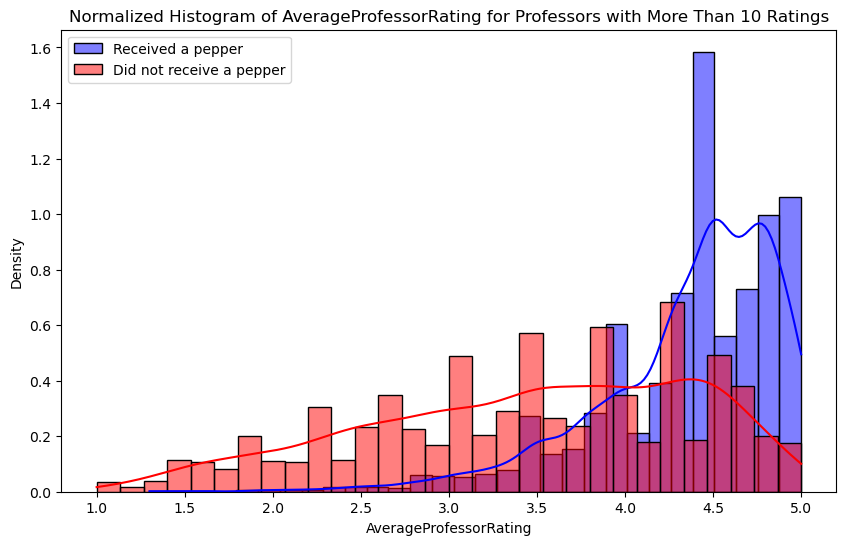

Median rating of professors with more than 10 ratings who received a pepper:  4.5 Median rating of professors with more than 10 ratings who did not receive a pepper:  3.5


In [141]:
# Plot the normalized histogram of the AverageProfessorRating for professors with more than 10 ratings who received a pepper and those who did not
plt.figure(figsize=(10, 6))
sns.histplot(df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 1]['AverageProfessorRating'], bins=30, kde=True, color='blue', label='Received a pepper', stat='density')
sns.histplot(df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 0]['AverageProfessorRating'], bins=30, kde=True, color='red', label='Did not receive a pepper', stat='density')
plt.title('Normalized Histogram of AverageProfessorRating for Professors with More Than 10 Ratings')
plt.xlabel('AverageProfessorRating')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print the median rating of professors with more than 10 ratings who received a pepper and those who did not
median_rating_pepper = df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 1]['AverageProfessorRating'].median()
median_rating_no_pepper = df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 0]['AverageProfessorRating'].median()

print('Median rating of professors with more than 10 ratings who received a pepper: ', median_rating_pepper, 'Median rating of professors with more than 10 ratings who did not receive a pepper: ', median_rating_no_pepper)

In [142]:


# Conduct a mannwhitneyu test to check if the AverageProfessorRating for professors who received a pepper is higher than those who did not
mannwhitneyu, p_val = stats.mannwhitneyu(df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 1]['AverageProfessorRating'], df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 0]['AverageProfessorRating'], method='asymptotic')

print('mannwhitneyu Test Statistic: ', mannwhitneyu, 'P-value: ', p_val)

# Conduct a KS test to check if the AverageProfessorRating for professors who received a pepper is higher than those who did not
ks_stat, p_val = stats.ks_2samp(df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 1]['AverageProfessorRating'], df_capstone_num_clean[df_capstone_num_clean['Received a pepper'] == 0]['AverageProfessorRating'])

print('KS Statistic: ', ks_stat, 'P-value: ', p_val)

mannwhitneyu Test Statistic:  19456180.0 P-value:  0.0
KS Statistic:  0.46669951982426594 P-value:  0.0


In [143]:
# Conduct an Kruskal-Wallis test to check if the AverageProfessorRating for professors who received a pepper is higher than those who did not for male and female professors separately
kw, p_val = stats.kruskal(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'])

print('Kruskal-Wallis Test Statistic: ', kw, 'P-value: ', p_val)

Kruskal-Wallis Test Statistic:  2065.2327248608203 P-value:  0.0


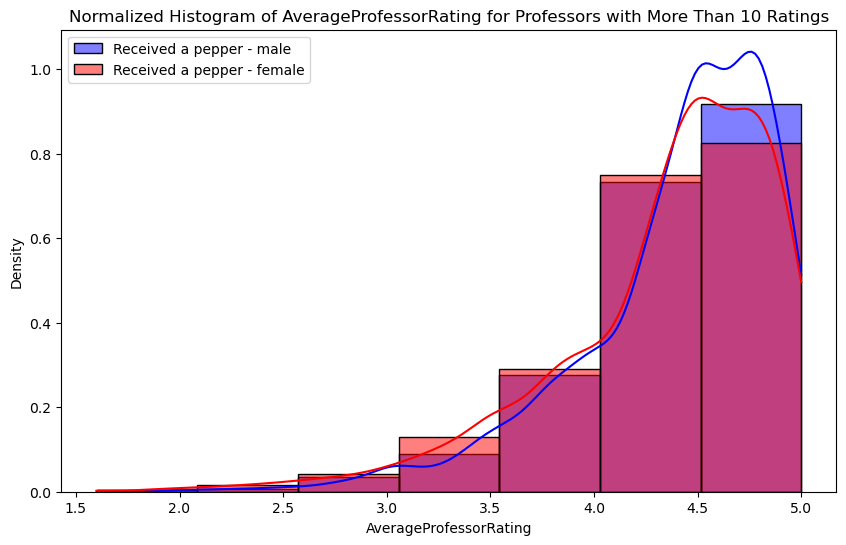

In [144]:
# Plot a histogram of the AverageProfessorRating for professors with more than 10 ratings who received a pepper male vs female
plt.figure(figsize=(10, 6))
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], bins=7, kde=True, color='blue', label='Received a pepper - male', stat='density')
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], bins=7, kde=True, color='red', label='Received a pepper - female', stat='density')
plt.title('Normalized Histogram of AverageProfessorRating for Professors with More Than 10 Ratings')
plt.xlabel('AverageProfessorRating')
plt.ylabel('Density')
plt.legend()
plt.show()    

In [145]:
# Conduct a mannwhitneyu test to check if the AverageProfessorRating for professors who received a pepper and are male vs those who didnt
mannwhitneyu, p_val = stats.mannwhitneyu(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], method='asymptotic')

print('mannwhitneyu Test Statistic - received a pepper: ', mannwhitneyu, 'P-value: ', p_val)

# Conduct a mannwhitneyu test to check if the AverageProfessorRating for professors who received a pepper is higher than those for female
mannwhitneyu, p_val = stats.mannwhitneyu(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], method='asymptotic')

print('mannwhitneyu Test Statistic - did not: ', mannwhitneyu, 'P-value: ', p_val)

# Conduct a KS test to check if the AverageProfessorRating for professors who received a pepper is higher than those for male
mannwhitneyu, p_val = stats.ks_2samp(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'])

print('KS Statistic - pepper: ', ks_stat, 'P-value: ', p_val)

# Conduct a KS test to check if the AverageProfessorRating for professors who received a pepper is higher than those for female
ks_stat, p_val = stats.ks_2samp(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'])

print('KS Statistic- no pepper: ', ks_stat, 'P-value: ', p_val)

mannwhitneyu Test Statistic - received a pepper:  1899495.0 P-value:  0.003035499250100694
mannwhitneyu Test Statistic - did not:  2004810.0 P-value:  4.7632764991600096e-05
KS Statistic - pepper:  0.46669951982426594 P-value:  0.036054048258917094
KS Statistic- no pepper:  0.06410445272148024 P-value:  0.0007291292605801063


In [146]:
df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'].describe()


count    2071.000000
mean        4.409464
std         0.484142
min         1.600000
25%         4.200000
50%         4.500000
75%         4.800000
max         5.000000
Name: AverageProfessorRating, dtype: float64

In [147]:
# mean rating of professors who received a pepper male 
df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'].describe()



count    1738.000000
mean        4.349425
std         0.539624
min         1.600000
25%         4.100000
50%         4.500000
75%         4.800000
max         5.000000
Name: AverageProfessorRating, dtype: float64

In [148]:
# Calculate the effect size of males vs female professors who received a pepper
mean_diff = df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'].mean() - df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'].mean()

# Get the pooled standard deviation
std_diff = np.sqrt((df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'].std() ** 2 + df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'].std() ** 2) / 2)

effect_size = mean_diff / std_diff

print('Effect size - professors who received a pepper: ', effect_size)

Effect size - professors who received a pepper:  0.117119372427711


In [149]:
import numpy as np
from scipy.stats import mannwhitneyu

# Parameters
n_simulations = 10000  # Number of simulations
n1 = 2071  # Sample size for male professors who received a pepper
n2 = 1738  # Sample size for female professors who received a pepper
alpha = 0.005  # Significance level

# Distributions under the alternative hypothesis
# For example, group 1 has a median of 0, group 2 has a median of effect_size
effect_size = 0.117

# Initialize counter for significant results
significant_results = 0

for _ in range(n_simulations):
    # Generate samples
    sample1 = np.random.normal(loc=0, scale=1, size=n1)
    sample2 = np.random.normal(loc=effect_size, scale=1, size=n2)
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    
    # Check if the result is significant
    if p_value < alpha:
        significant_results += 1

# Calculate power
power = significant_results / n_simulations

print(f"Estimated Power: {power:.4f}")


Estimated Power: 0.7647


95% Confidence Interval for males who received a pepper: [4.39, 4.43]


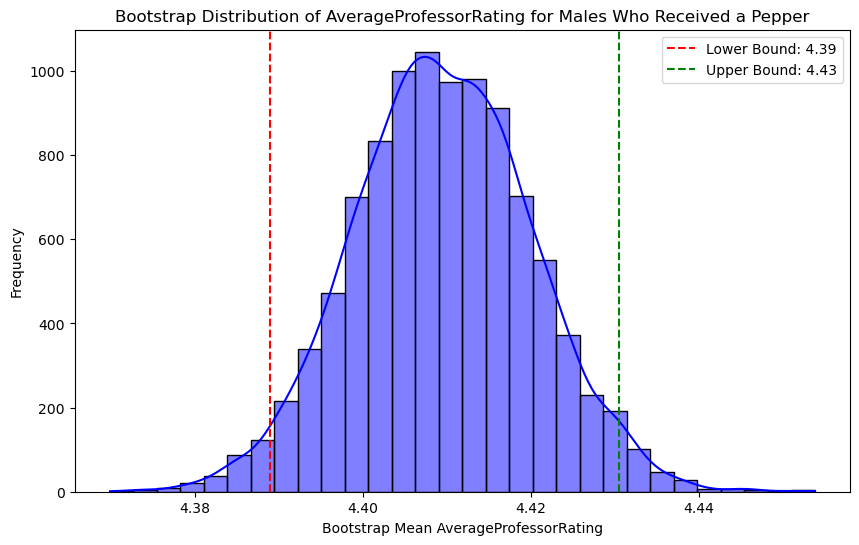

In [150]:
# Bootstrap method to calculate the confidence interval
n_bootstrap = 10000
bootstrap_means = []

male_pepper_ratings = df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating']

for _ in range(n_bootstrap):
    bootstrap_sample = male_pepper_ratings.sample(n=len(male_pepper_ratings), replace=True)
    bootstrap_means.append(bootstrap_sample.mean())

# Calculate the 95% confidence interval
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(f"95% Confidence Interval for males who received a pepper: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Plot the bootstrap distribution and confidence interval
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_means, bins=30, kde=True, color='blue')
plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')
plt.title('Bootstrap Distribution of AverageProfessorRating for Males Who Received a Pepper')
plt.xlabel('Bootstrap Mean AverageProfessorRating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

95% Confidence Interval for males who received a pepper: [4.32, 4.37]


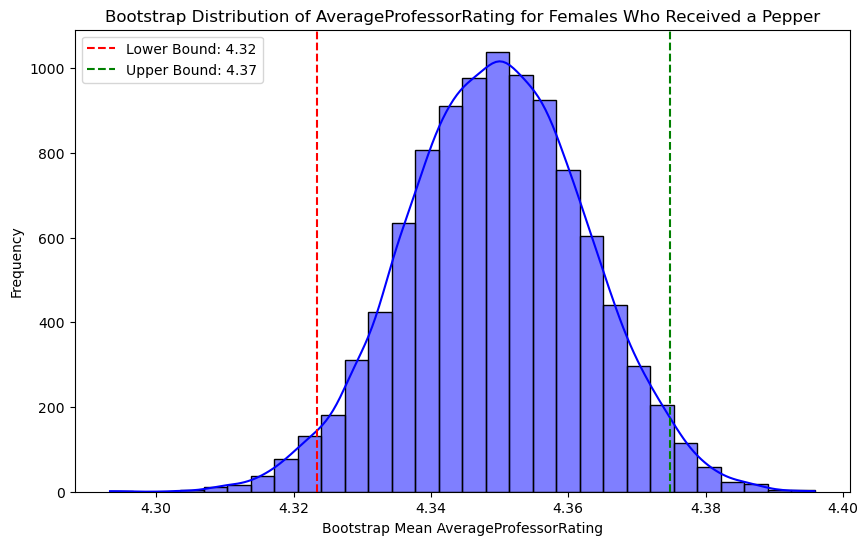

In [151]:
# Bootstrap method to calculate the confidence interval
n_bootstrap = 10000
bootstrap_means = []

female_pepper_ratings = df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating']

for _ in range(n_bootstrap):
    bootstrap_sample = female_pepper_ratings.sample(n=len(female_pepper_ratings), replace=True)
    bootstrap_means.append(bootstrap_sample.mean())

# Calculate the 95% confidence interval
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(f"95% Confidence Interval for males who received a pepper: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Plot the bootstrap distribution and confidence interval
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_means, bins=30, kde=True, color='blue')
plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')
plt.title('Bootstrap Distribution of AverageProfessorRating for Females Who Received a Pepper')
plt.xlabel('Bootstrap Mean AverageProfessorRating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

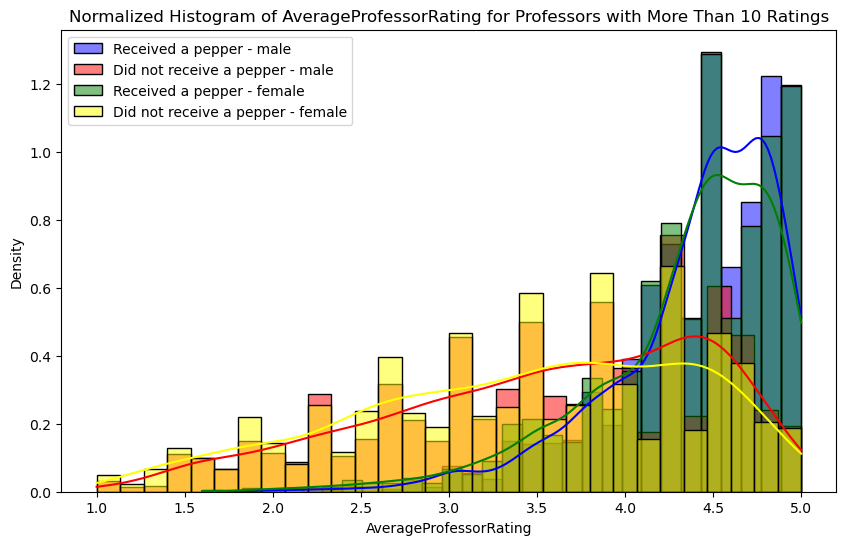

In [152]:
# Create a histogram of the AverageProfessorRating for professors with more than 10 ratings who received a pepper and those who did not for male and female
plt.figure(figsize=(10, 6))
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='blue', label='Received a pepper - male', stat='density')
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='red', label='Did not receive a pepper - male', stat='density')
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='green', label='Received a pepper - female', stat='density')
sns.histplot(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'], bins=30, kde=True, color='yellow', label='Did not receive a pepper - female', stat='density')
plt.title('Normalized Histogram of AverageProfessorRating for Professors with More Than 10 Ratings')
plt.xlabel('AverageProfessorRating')
plt.ylabel('Density')
plt.legend()
plt.show()

In [153]:
df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'].describe()


count    1738.000000
mean        4.349425
std         0.539624
min         1.600000
25%         4.100000
50%         4.500000
75%         4.800000
max         5.000000
Name: AverageProfessorRating, dtype: float64

In [154]:
# Print the median of the AverageProfessorRating for professors with more than 10 ratings who received a pepper and those who did not male and female
median_rating_male_pepper = df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'].median()
median_rating_male_no_pepper = df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'].median()
median_rating_female_pepper = df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'].median()
median_rating_female_no_pepper = df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'].median()
print('Median rating of professors with more than 10 ratings who received a pepper - male', median_rating_male_pepper, 'Did not receive a pepper - male', median_rating_male_no_pepper, 'Received a pepper - female', median_rating_female_pepper, 'Did not receive a pepper - female', median_rating_female_no_pepper)

Median rating of professors with more than 10 ratings who received a pepper - male 4.5 Did not receive a pepper - male 3.7 Received a pepper - female 4.5 Did not receive a pepper - female 3.5


In [155]:
len_male_pepper = len(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'])
len_male_no_pepper = len(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfMale'] == 1)]['AverageProfessorRating'])
len_female_pepper = len(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 1) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'])
len_female_no_pepper = len(df_capstone_num_clean[(df_capstone_num_clean['Received a pepper'] == 0) & (df_capstone_num_clean['HighConfFemale'] == 1)]['AverageProfessorRating'])

print('Length of male professors who received a pepper:', len_male_pepper)
print('Length of male professors who did not receive a pepper:', len_male_no_pepper)
print('Length of female professors who received a pepper:', len_female_pepper)
print('Length of female professors who did not receive a pepper:', len_female_no_pepper)

Length of male professors who received a pepper: 2071
Length of male professors who did not receive a pepper: 2217
Length of female professors who received a pepper: 1738
Length of female professors who did not receive a pepper: 1681


Q7. Build a regression model predicting average rating from all numerical predictors (the ones in the rmpCapstoneNum.csv) file. Make sure to include the R2and RMSE of this model. Which of these factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns

In [156]:
df_capstone = pd.read_csv('./rmpCapstoneNum.csv', header=None)
df_capstone.columns = ['Average Rating', 'Average Difficulty', 'Number of ratings', 'Received a pepper', 
                       'Proportion of students that said they would take the class again', 
                       'Number of ratings coming from online classes', 'Male Professor', 'Female Professor']

In [157]:
df_capstone.isna().sum()

Average Rating                                                      19889
Average Difficulty                                                  19889
Number of ratings                                                   19889
Received a pepper                                                   19889
Proportion of students that said they would take the class again    77733
Number of ratings coming from online classes                        19889
Male Professor                                                          0
Female Professor                                                        0
dtype: int64

In [158]:
df_capstone_na_dropped=df_capstone.drop(columns=['Proportion of students that said they would take the class again']).dropna()

In [159]:
df_capstone_na_dropped['Proportion of online class ratings'] = df_capstone_na_dropped['Number of ratings coming from online classes'].div(df_capstone_na_dropped['Number of ratings'])

In [160]:
df_capstone_na_dropped

,Average Rating,Average Difficulty,Number of ratings,Received a pepper,Number of ratings coming from online classes,Male Professor,Female Professor,Proportion of online class ratings
0,5.0,1.5,2.0,0.0,0.0,0,1,0.000000
2,3.2,3.0,4.0,0.0,0.0,1,0,0.000000
3,3.6,3.5,10.0,1.0,0.0,0,0,0.000000
4,1.0,5.0,1.0,0.0,0.0,0,0,0.000000
5,3.5,3.3,22.0,0.0,7.0,1,0,0.318182
...,...,...,...,...,...,...,...,...
89885,3.9,3.8,4.0,1.0,0.0,0,1,0.000000
89888,2.5,2.5,2.0,0.0,0.0,0,0,0.000000
89889,4.5,2.0,2.0,0.0,0.0,1,0,0.000000
89890,5.0,1.7,6.0,1.0,2.0,1,0,0.333333


In [161]:
df_capstone_greater_than_10=df_capstone_na_dropped[df_capstone_na_dropped['Number of ratings'] >= 10]

In [162]:
df_capstone_greater_than_10

,Average Rating,Average Difficulty,Number of ratings,Received a pepper,Number of ratings coming from online classes,Male Professor,Female Professor,Proportion of online class ratings
3,3.6,3.5,10.0,1.0,0.0,0,0,0.000000
5,3.5,3.3,22.0,0.0,7.0,1,0,0.318182
21,2.6,4.1,10.0,0.0,0.0,1,0,0.000000
25,4.3,3.3,16.0,1.0,0.0,0,1,0.000000
39,3.5,3.2,20.0,1.0,0.0,1,0,0.000000
...,...,...,...,...,...,...,...,...
89841,4.2,3.8,11.0,0.0,0.0,0,1,0.000000
89855,4.0,1.9,11.0,1.0,0.0,1,0,0.000000
89866,4.4,3.6,14.0,1.0,0.0,0,1,0.000000
89875,2.8,2.9,16.0,0.0,13.0,0,0,0.812500


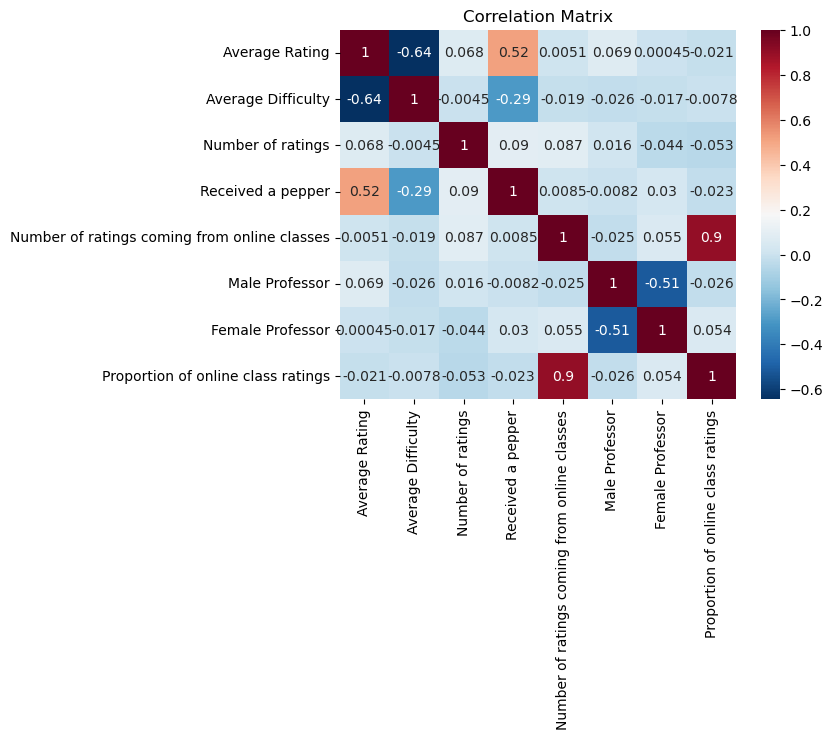

In [163]:
correlation_matrix = df_capstone_greater_than_10.corr()

sns.heatmap(correlation_matrix,cmap = "RdBu_r", annot=True)
plt.title('Correlation Matrix')
plt.show()

In [164]:
df_capstone_dropped_final=df_capstone_greater_than_10.drop(columns=['Number of ratings coming from online classes'])

In [165]:
df_capstone_dropped_final=df_capstone_dropped_final[(df_capstone_dropped_final['Male Professor']==1) & (df_capstone_dropped_final['Female Professor']==0) | (df_capstone_dropped_final['Male Professor']==0) & (df_capstone_dropped_final['Female Professor']==1)]

In [166]:
df_capstone_dropped_final=df_capstone_dropped_final.drop(columns=['Male Professor'])

In [167]:
df_capstone_dropped_final.columns

Index(['Average Rating', 'Average Difficulty', 'Number of ratings',
       'Received a pepper', 'Female Professor',
       'Proportion of online class ratings'],
      dtype='object')

In [168]:
alphas=np.linspace(0.0001, 10000, num=50)

In [169]:
import numpy as np
from sklearn.model_selection import KFold  

X = np.array([
    df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Number of ratings'],
    df_capstone_dropped_final['Received a pepper'],
    df_capstone_dropped_final['Female Professor'],
    df_capstone_dropped_final['Proportion of online class ratings']
]).T

y = np.array(df_capstone_dropped_final['Average Rating'])

X = np.hstack((np.ones((X.shape[0], 1)), X))

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def normal_regression(X_train, y_train):
    return np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

def ridge_regression(X_train, y_train, alpha):
    n_features = X_train.shape[1]
    identity = np.eye(n_features)
    identity[0, 0] = 0  
    return np.linalg.inv(X_train.T @ X_train + alpha * identity) @ X_train.T @ y_train

def lasso_regression(X_train, y_train, alpha, max_iter=1000, tol=1e-4):
    m, n = X_train.shape
    beta = np.zeros(n)
    for _ in range(max_iter):
        beta_old = beta.copy()
        for j in range(n):
            residual = y_train - X_train @ beta + X_train[:, j] * beta[j]
            rho = X_train[:, j].T @ residual
            if j == 0:  
                beta[j] = rho / (X_train[:, j].T @ X_train[:, j])
            else:
                beta[j] = np.sign(rho) * max(0, abs(rho) - alpha) / (X_train[:, j].T @ X_train[:, j])
        if np.max(np.abs(beta - beta_old)) < tol:
            break
    return beta

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Normal Regression
    beta_normal = normal_regression(X_train, y_train)
    y_pred_normal = X_test @ beta_normal
    rmse_normal = compute_rmse(y_test, y_pred_normal)
    r2_normal = compute_r2(y_test, y_pred_normal)
    
    # Ridge Regression
    for alpha in alphas:
        beta_ridge = ridge_regression(X_train, y_train, alpha)
        y_pred_ridge = X_test @ beta_ridge
        rmse_ridge = compute_rmse(y_test, y_pred_ridge)
        r2_ridge = compute_r2(y_test, y_pred_ridge)
        results.append(('Ridge', alpha, rmse_ridge, r2_ridge))
    
    # Lasso Regression
    for alpha in alphas:
        beta_lasso = lasso_regression(X_train, y_train, alpha)
        y_pred_lasso = X_test @ beta_lasso
        rmse_lasso = compute_rmse(y_test, y_pred_lasso)
        r2_lasso = compute_r2(y_test, y_pred_lasso)
        results.append(('Lasso', alpha, rmse_lasso, r2_lasso))
    
    results.append(('Normal', None, rmse_normal, r2_normal))

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])


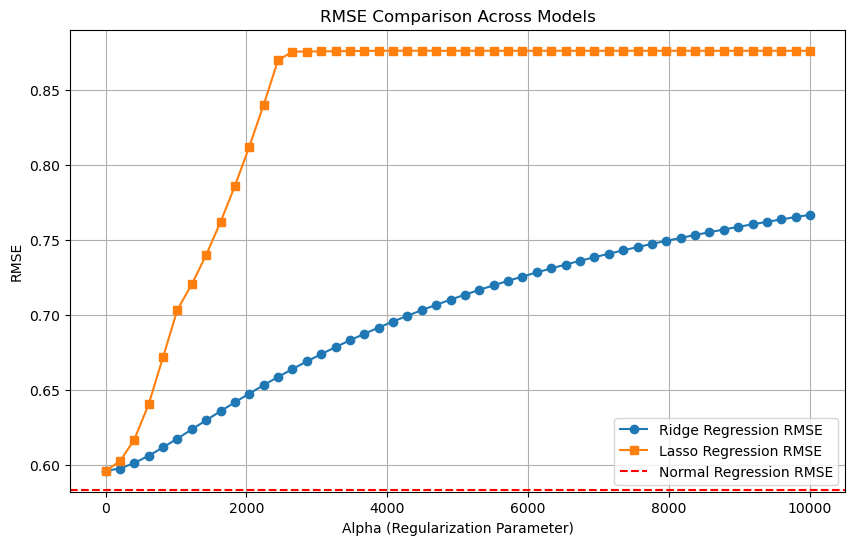

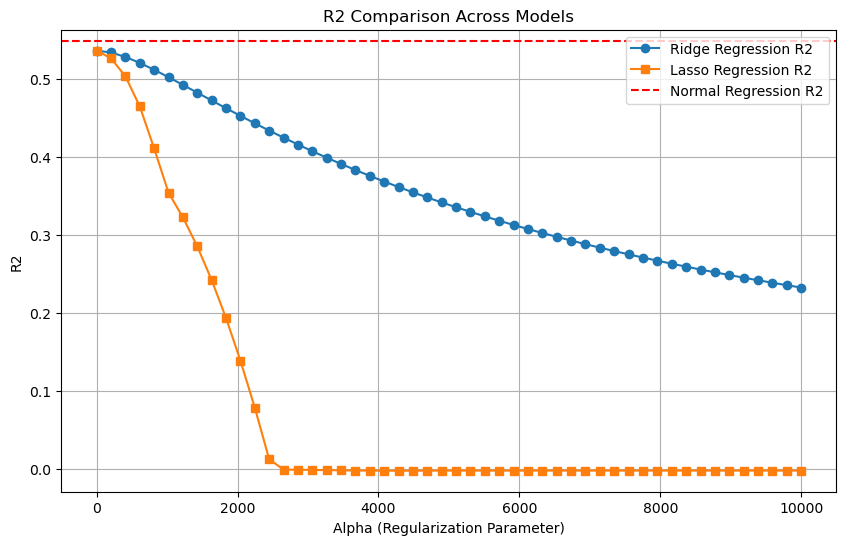

In [170]:
ridge_results = results_df[results_df['Model'] == 'Ridge'].drop(columns=['Model']).groupby('Alpha').mean()
lasso_results = results_df[results_df['Model'] == 'Lasso'].drop(columns=['Model']).groupby('Alpha').mean()
normal_results = normal_results = results_df[results_df['Model'] == 'Normal']

plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_results['RMSE'], marker='o', label='Ridge Regression RMSE')
plt.plot(alphas, lasso_results['RMSE'], marker='s', label='Lasso Regression RMSE')

plt.axhline(y=normal_results['RMSE'].values[0], color='r', linestyle='--', label='Normal Regression RMSE')

plt.title('RMSE Comparison Across Models')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Plot R^2 for each model
plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_results['R2'], marker='o', label='Ridge Regression R2')
plt.plot(alphas, lasso_results['R2'], marker='s', label='Lasso Regression R2')

# Normal regression has no alpha, plot it as a horizontal line
plt.axhline(y=normal_results['R2'].values[0], color='r', linestyle='--', label='Normal Regression R2')

plt.title('R2 Comparison Across Models')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.show()
